# Scalable GP Regression (w/ KISS-GP)

This example shows how to use a `GridInterpolationKernel` module. This regression module is designed for when the function you're modeling has 2-3 dimensional inputs and you don't believe that the output can be additively decomposed.

In this example, we’re modeling $y=sin(2\pi(x_0+x_1))$
 
`GridInterpolationKernel` exploits Kronecker structure in the inducing points

In [1]:
import math
import torch
import gpytorch
import numpy
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

%matplotlib inline

In [2]:
# We make an nxn grid of training points spaced every 1/(n-1) on [0,1]x[0,1]
n = 40
train_x = torch.zeros(pow(n, 2), 2)
for i in range(n):
    for j in range(n):
        train_x[i * n + j][0] = float(i) / (n-1)
        train_x[i * n + j][1] = float(j) / (n-1)
train_x = Variable(train_x)
# True function is sin( 2*pi*(x0+x1))
train_y = Variable(torch.sin(((train_x.data[:, 0] + train_x.data[:, 1]) * (2 * math.pi))))

In [4]:
# We use KISS-GP (kernel interpolation for scalable structured Gaussian Processes)
# as in https://arxiv.org/pdf/1503.01057.pdf
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        # Near-zero mean
        self.mean_module = ConstantMean()
        # GridInterpolationKernel over an ExactGP
        self.base_covar_module = RBFKernel()
        self.covar_module = GridInterpolationKernel(self.base_covar_module, grid_size=30,
                                                    grid_bounds=[(0, 1), (0, 1)])
        # Register the log lengthscale as a trainable parameter
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return GaussianRandomVariable(mean_x, covar_x)

# Initialize the likelihood and model
# We use a Gaussian likelihood for regression so we have both a predictive
# mean and variance for our predictions
likelihood = GaussianLikelihood()
model = GPRegressionModel(train_x.data, train_y.data, likelihood)

In [5]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def train():
    training_iterations = 30
    for i in range(training_iterations):
        # Zero out gradients from backprop
        optimizer.zero_grad()
        # Get predicitve mean and variance
        output = model(train_x)
        # Calculate loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.data[0]))
        optimizer.step()
%time train()

Iter 1/30 - Loss: 1.142
Iter 2/30 - Loss: 1.091
Iter 3/30 - Loss: 1.032
Iter 4/30 - Loss: 0.971
Iter 5/30 - Loss: 0.911
Iter 6/30 - Loss: 0.854
Iter 7/30 - Loss: 0.793
Iter 8/30 - Loss: 0.713
Iter 9/30 - Loss: 0.626
Iter 10/30 - Loss: 0.536
Iter 11/30 - Loss: 0.469
Iter 12/30 - Loss: 0.409
Iter 13/30 - Loss: 0.359
Iter 14/30 - Loss: 0.307
Iter 15/30 - Loss: 0.264
Iter 16/30 - Loss: 0.216
Iter 17/30 - Loss: 0.166
Iter 18/30 - Loss: 0.114
Iter 19/30 - Loss: 0.080
Iter 20/30 - Loss: 0.034
Iter 21/30 - Loss: -0.016
Iter 22/30 - Loss: -0.063
Iter 23/30 - Loss: -0.123
Iter 24/30 - Loss: -0.172
Iter 25/30 - Loss: -0.234
Iter 26/30 - Loss: -0.279
Iter 27/30 - Loss: -0.336
Iter 28/30 - Loss: -0.401
Iter 29/30 - Loss: -0.444
Iter 30/30 - Loss: -0.512
CPU times: user 22.2 s, sys: 844 ms, total: 23.1 s
Wall time: 6.73 s


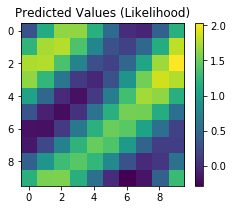

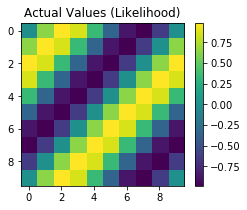

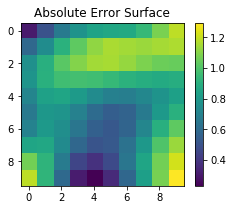

In [6]:
# Set model and likelihood into evaluation mode
model.eval()
likelihood.eval()

# Generate nxn grid of test points spaced on a grid of size 1/(n-1) in [0,1]x[0,1]
n = 10
test_x = Variable(torch.zeros(int(pow(n, 2)), 2))
for i in range(n):
    for j in range(n):
        test_x.data[i * n + j][0] = float(i) / (n-1)
        test_x.data[i * n + j][1] = float(j) / (n-1)

# Calculate mean and predictive variance
observed_pred = likelihood(model(test_x))
# Labels are predictive means
pred_labels = observed_pred.mean().view(n, n).data.numpy()

# Compute actual data from true function
test_y_actual = torch.sin(((test_x.data[:, 0] + test_x.data[:, 1]) * (2 * math.pi))).numpy().reshape(n, n)
# Calc abosolute error
delta_y = numpy.absolute(pred_labels - test_y_actual)

# Define a plotting function
def ax_plot(f, ax, y_labels, title):
    im = ax.imshow(y_labels)
    ax.set_title(title)
    f.colorbar(im)

# Plot our predictive means
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax, pred_labels, 'Predicted Values (Likelihood)')

# Plot the true values
f, observed_ax2 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax2, test_y_actual, 'Actual Values (Likelihood)')

# Plot the absolute errors
f, observed_ax3 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax3, delta_y, 'Absolute Error Surface')